In [1]:
!pip install chess

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 7.3 MB/s eta 0:00:00


In [2]:
import chess
import pandas as pd



In [3]:
import numpy as np
import chess.engine
import chess.pgn


In [33]:
from math import sqrt, log
import random

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split


In [5]:
import dask as dd

In [6]:

# import csv

# def pgn_to_fen_csv(pgn_file, output_csv):
#     with open(pgn_file) as pgn, open(output_csv, 'w', newline='') as csvfile:
#         writer = csv.writer(csvfile)
#         # Write the header row
#         writer.writerow(["White", "Black", "Result", "Move_Number", "Move", "FEN"])
        
#         game_count = 0
        
#         while True:
#             game = chess.pgn.read_game(pgn)
#             if game is None:
#                 break
            
#             game_count += 1
#             board = game.board()
#             moves = list(game.mainline_moves())
            
#             # Extract game metadata
#             white = game.headers.get("White", "Unknown")
#             black = game.headers.get("Black", "Unknown")
#             result = game.headers.get("Result", "*")
            
#             # Write the initial position
#             writer.writerow([white, black, result, 0, "Initial", board.fen()])
            
#             # Process and write each move's FEN
#             for i, move in enumerate(moves, 1):
#                 board.push(move)
#                 writer.writerow([white, black, result, i, move.uci(), board.fen()])
        
#         print(f"Processed {game_count} games")

# # Usage
# pgn_file_path = '/kaggle/input/chess-pgn/combined_700-800.pgn'
# csv_file_path = '/kaggle/working/fen_data.csv'

# pgn_to_fen_csv(pgn_file_path, csv_file_path)


In [7]:
!pip install gdown

In [8]:
import gdown

file_id = '1fjl6XEMyYL3WXyo0Bp2_tTC-kzIzZcdv'  # Replace with your actual file ID
destination = 'fen.csv'      # Replace with the desired file name

gdown.download(f'https://drive.google.com/uc?id={file_id}', destination, quiet=False)



Downloading...
From (original): https://drive.google.com/uc?id=1fjl6XEMyYL3WXyo0Bp2_tTC-kzIzZcdv
From (redirected): https://drive.google.com/uc?id=1fjl6XEMyYL3WXyo0Bp2_tTC-kzIzZcdv&confirm=t&uuid=a0fd2192-138d-400d-94f6-90ccff0a4be3
To: /kaggle/working/fen.csv
 26%|██▌       | 2.41G/9.23G [00:17<01:28, 77.1MB/s]

KeyboardInterrupt: 

In [ ]:

chunksize = 100000  # Number of rows per chunk
chunks = []
count=0
# Read in chunks
for chunk in pd.read_csv('/kaggle/working/fen.csv', chunksize=chunksize):
    # Process each chunk (if needed)
    chunks.append(chunk)
    count+=1
    if count==200:
        break

# Concatenate all chunks into a single DataFrame
df = pd.concat(chunks, ignore_index=True)


In [ ]:
df['Move']=df['Move'].shift(-1)

In [ ]:
df

In [ ]:
df=df[df['Move']!= 'Initial']
df=df.dropna()
df

In [34]:
class MCTSNode:
    def __init__(self, state, parent=None, move=None):
        self.state = state  # Current board state
        self.parent = parent  # Parent node
        self.move = move  # The move that led to this state
        self.children = []  # List of child nodes
        self.visits = 0  # Number of times this node was visited
        self.value = 0  # Value of this node (win/loss/draw)

    def is_fully_expanded(self):
        return len(self.children) == len(list(self.state.legal_moves))

    def best_child(self, c_param=1.4):
        choices_weights = [
            (child.value / child.visits) + c_param * sqrt((2 * log(self.visits) / child.visits))
            for child in self.children
        ]
        return self.children[np.argmax(choices_weights)]

    def rollout_policy(self, legal_moves):
        return random.choice(legal_moves)

    def expand(self):
        legal_moves = list(self.state.legal_moves)
        for move in legal_moves:
            if move not in [child.move for child in self.children]:
                next_state = self.state.copy()
                next_state.push(move)
                child_node = MCTSNode(next_state, parent=self, move=move)
                self.children.append(child_node)
                return child_node

    def simulate(self):
        current_simulation_state = self.state.copy()
        while not current_simulation_state.is_game_over():
            legal_moves = list(current_simulation_state.legal_moves)
            move = self.rollout_policy(legal_moves)
            current_simulation_state.push(move)
        result = current_simulation_state.result()
        if result == '1-0':
            return 1
        elif result == '0-1':
            return -1
        else:
            return 0

    def backpropagate(self, result):
        self.visits += 1
        self.value += result
        if self.parent:
            self.parent.backpropagate(-result)


In [35]:
def mcts(root, n_simulations):
    for _ in range(n_simulations):
        node = root
        while node.is_fully_expanded() and node.children:
            node = node.best_child()

        if not node.state.is_game_over():
            node = node.expand()

        result = node.simulate()
        node.backpropagate(result)

    return root.best_child(c_param=0)  # Return the move with the highest win rate


In [10]:
sq_idx ={
     'a':0,
     'b':1,
     'c':2,
     'd':3,
     'e':4,
     'f':5,
     'g':6,
     'h':7
 }


def sq_to_idx(square):
    name=chess.square_name(square)
    return 8-int(name[1]),sq_idx[name[0]]


In [11]:

def encode_board(fen):
    board = chess.Board(fen)
    board_features = np.zeros((6, 8, 8), dtype=int)

    for piece in chess.PIECE_TYPES:
        # Encode white pieces
        for square in board.pieces(piece, chess.WHITE):
            row, col = 7 - square // 8, square % 8  # Convert square index to row, col
            board_features[piece-1, row, col] = 1

        # Encode black pieces
        for square in board.pieces(piece, chess.BLACK):
            row, col = 7 - square // 8, square % 8
            board_features[piece-1, row, col] = -1

    return board_features



In [12]:
encode_board('rnbqkbnr/pppppppp/8/8/8/5N2/PPPPPPPP/RNBQKB1R b KQkq - 1 1')

array([[[ 0,  0,  0,  0,  0,  0,  0,  0],
        [-1, -1, -1, -1, -1, -1, -1, -1],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 1,  1,  1,  1,  1,  1,  1,  1],
        [ 0,  0,  0,  0,  0,  0,  0,  0]],

       [[ 0, -1,  0,  0,  0,  0, -1,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  1,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  1,  0,  0,  0,  0,  0,  0]],

       [[ 0,  0, -1,  0,  0, -1,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  1,  0,  0,  

In [13]:
def move2mat(move,fen):
    board=chess.Board(fen)
    board.push_san(move).uci()
    move=str(board.pop())
    from_output_layer=np.zeros((8,8),dtype=int)
    from_row=8-int(move[1])
    from_col=sq_idx[move[0]]
    from_output_layer[from_row][from_col]=1


    to_output_layer=np.zeros((8,8),dtype=int)
    to_row=8-int(move[3])
    to_col=sq_idx[move[2]]
    to_output_layer[to_row][to_col]=1

    return np.stack([from_output_layer,to_output_layer])

In [14]:
move2mat('d7d5', 'rnbqkbnr/pppppppp/8/8/8/5N2/PPPPPPPP/RNBQKB1R b KQkq - 1 1')

array([[[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]]])

In [ ]:
# def encode_moves_batch(moves, initial_fen):
#     board = chess.Board(initial_fen)
#     encoded_moves = np.zeros((len(moves), 2, 8, 8), dtype=int)

#     for i, move in enumerate(moves):
#         encoded_moves[i] = move2mat(move, board)
    
#     return encoded_moves
# y_train = [encode_moves_batch(moves, initial_fen) for moves, initial_fen in zip(df['moves'], df['FEN'])]

In [15]:
class ChessDataset(Dataset):
    
    def __init__(self, df):
        """
        Args:
            df (pd.DataFrame): DataFrame with columns 'FEN' and 'Move'.
        """
        super(ChessDataset, self).__init__()
        self.df = df.reset_index(drop=True)  # Ensure proper indexing
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        # Randomly sample an index
        game_index = np.random.randint(0, len(self.df))
        
        # Retrieve FEN and move
        fen = self.df.loc[game_index, 'FEN']
        move = self.df.loc[game_index, 'Move']
        
    
        x = encode_board(fen)
        y = move2mat(move,fen)  # Assume move2mat encodes move
        
        # Apply board state adjustment if needed
        if game_index % 2 == 1:
            x *= -1
        
        return x, y


In [ ]:
x_train=ChessDataset(df[['FEN','Move']])
train_loader=DataLoader(x_train,batch_size=32,shuffle=True,drop_last=True)

In [16]:
class module(nn.Module):

    def __init__(self, hidden_size):
        super(module, self).__init__()
        self.conv1 = nn.Conv2d(hidden_size, hidden_size, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(hidden_size, hidden_size, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(hidden_size)
        self.bn2 = nn.BatchNorm2d(hidden_size)
        self.activation1 = nn.SELU()
        self.activation2 = nn.SELU()

    def forward(self, x):
        x_input = torch.clone(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = x + x_input
        x = self.activation2(x)
        return x


In [17]:
class ChessNet(nn.Module):

    def __init__(self, hidden_layers=4, hidden_size=256):
        super(ChessNet, self).__init__()
        self.hidden_layers = hidden_layers
        self.input_layer = nn.Conv2d(6, hidden_size, 3, stride=1, padding=1)
        self.module_list = nn.ModuleList([module(hidden_size) for i in range(hidden_layers)])
        self.output_layer = nn.Conv2d(hidden_size, 2, 3, stride=1, padding=1)

    def forward(self, x):
        x = self.input_layer(x)
        x = F.relu(x)

        for i in range(self.hidden_layers):
            x = self.module_list[i](x)

        x = self.output_layer(x)
        return x


In [18]:

model = ChessNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  


In [19]:
criterion_from = nn.CrossEntropyLoss()
criterion_to = nn.CrossEntropyLoss()



In [20]:
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the GPU
model = model.to(device)

In [21]:
model

ChessNet(
  (input_layer): Conv2d(6, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (module_list): ModuleList(
    (0-3): 4 x module(
      (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation1): SELU()
      (activation2): SELU()
    )
  )
  (output_layer): Conv2d(256, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [ ]:
num_epochs = 1

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch_idx, (x, y) in enumerate(train_loader):

        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        output = model(x.float())  


        loss_from = criterion_from(output[:, 0, :, :], y[:, 0, :, :].float())
        loss_to = criterion_to(output[:, 1, :, :], y[:, 1, :, :].float())
        loss = loss_from + loss_to


        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if batch_idx % 100 == 99: 
            print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}], Loss: {running_loss / 100:.4f}')
            running_loss = 0.0

    print(f'Epoch [{epoch + 1}/{num_epochs}] finished.')

print('Training finished.')

In [ ]:
# torch.save(model,'/kaggle/working/model_14M.pth')

In [24]:
model=torch.load('/kaggle/input/model_30/pytorch/default/1/model_30M.pth')

/tmp/ipykernel_36/3687973243.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model=torch.load('/kaggle/input/model_30/pytorch/default/1/model_30M.pth')


In [25]:

def predict(model, x):
    model.eval()

    with torch.no_grad():  
        x = x.to(device).float()
        output = model(x)
        output = output.cpu()

    return output


In [26]:
def check_mate_single(board):
    board = board.copy()
    legal_moves = list(board.legal_moves)
    for move in legal_moves:
        board.push_uci(str(move))
        if board.is_checkmate():
            move = board.pop()
            return move
        _ = board.pop()

In [27]:
def distribution_over_moves(vals):
    probs = np.array(vals)
    probs = np.exp(probs)
    probs = probs / probs.sum()
    probs = probs ** 3
    probs = probs / probs.sum()
    return probs

In [28]:
import numpy as np
import torch
import chess

sq_idx = {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7}

def choose_move(fen, color):
    board = chess.Board(fen)
    legal_moves = list(board.legal_moves)
    
    # Check for immediate checkmate
    move = check_mate_single(board)
    if move is not None:
        return move

    # Encode the board and pass it through the model
    x = torch.Tensor(encode_board(fen)).float().to('cuda')
    if color == chess.BLACK:
        x *= -1  # Invert the board for black
    x = x.unsqueeze(0)
    move = predict(model, x)
    move = torch.reshape(move, (2, 8, 8))
    
    # Extract the 'from' squares from legal moves
    froms = [str(legal_move)[:2] for legal_move in legal_moves]
    unique_froms = list(set(froms))
    vals = []

    # Calculate values for each unique 'from' square
    for from_ in unique_froms:
        val = move[0, 8 - int(from_[1]), sq_idx[from_[0]]]
        vals.append(val.item())
    
    # Normalize values to get a probability distribution
    probs = distribution_over_moves(vals)
    
    # Choose a 'from' square based on the probability distribution
    chosen_from = str(np.random.choice(unique_froms, size=1, p=probs)[0])[:2]
    vals = []

    # Calculate values for moves that start from the chosen 'from' square
    for legal_move in legal_moves:
        from_ = str(legal_move)[:2]
        to = str(legal_move)[2:]

        if from_ == chosen_from:
            val_move = move[1, 8 - int(to[1]), sq_idx[to[0]]]
            vals.append(val_move.item())
        else:
            vals.append(float('-inf'))  # Ensure invalid moves are not selected

    # Select the move with the highest value
    max_val_index = np.argmax(vals)
    chosen_move = legal_moves[max_val_index]
    
    # Final validation to ensure the move is legal
    if chosen_move in legal_moves:
        return chosen_move
    else:
        raise ValueError("Chosen move is not legal. There might be an issue with move selection logic.")


In [29]:
!pip install cairosvg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.5 MB/s eta 0:00:00


In [30]:
!pip install pillow

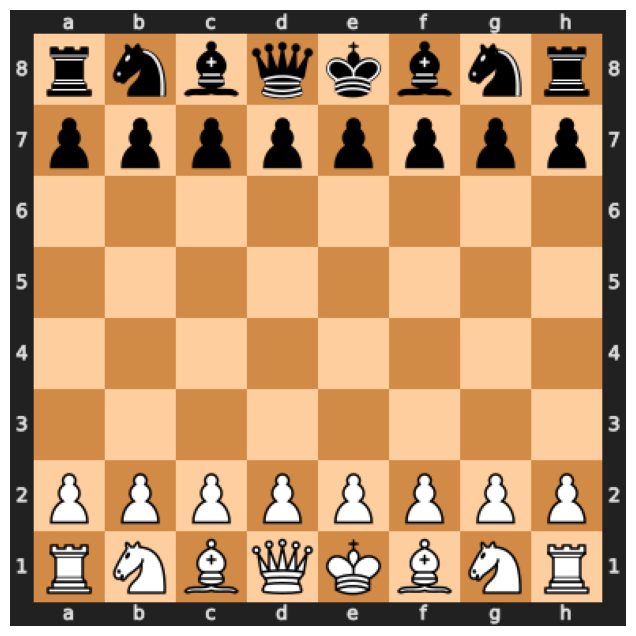

In [31]:
import chess
import chess.svg
import matplotlib.pyplot as plt
from cairosvg import svg2png
from PIL import Image
import io

# Create a new chess board
board = chess.Board()

# Convert the board to an SVG (Scalable Vector Graphics) image
board_svg = chess.svg.board(board)

# Convert SVG to PNG using cairosvg
png_output = io.BytesIO()
svg2png(bytestring=board_svg, write_to=png_output)
png_output.seek(0)

# Load the PNG image and display it using PIL and Matplotlib
image = Image.open(png_output)
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis('off')  # Turn off the axis
plt.show()


In [32]:
## prompt: make a for  loop that takes uci as input, pushes move to board and converts it to fen and pass it too choose move function, plays the move and displays it and asks for next move again as input, allow the user to choose color at start, and print board like in previous cell,  can you clear output cell before next iteration, keep its size a little smaller

import matplotlib.pyplot as plt
from IPython.display import clear_output

# Choose color
color_choice = input("Choose your color (White/Black): ").lower()
user_color = chess.WHITE if color_choice == 'white' else chess.BLACK

# Initialize board
board = chess.Board()

while not board.is_game_over():
  # Display the board
  clear_output()  # Clear the previous output
  board_svg = chess.svg.board(board)
  png_output = io.BytesIO()
  svg2png(bytestring=board_svg, write_to=png_output)
  png_output.seek(0)
  image = Image.open(png_output)
  plt.figure(figsize=(5, 5))  # Smaller figure size
  plt.imshow(image)
  plt.axis('off')
  plt.show()

  # User's turn
  if board.turn == user_color:
    uci_move = input("Enter your move (UCI format): ").lower()
    try:
      board.push_uci(uci_move)
    except ValueError:
      print("Invalid move. Try again.")
      continue

  # AI's turn
  else:
    fen = board.fen()
    ai_move = choose_move(fen, board.turn)
    print("AI's move:", ai_move)
    board.push(ai_move)

# Game over
print("Game over. Result:", board.result())


KeyboardInterrupt: Interrupted by user